In [1]:
#importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,classification_report

1. Pandas – library for data analysis and data manipulation
2. Matplotlib – library used for data visualization
3. Seaborn – a library based on matplotlib and it provides a high-level interface for data visualization
4. WordCloud – library to visualize text data
5. re – provides functions to pre-process the strings as per the given regular expression
6. nltk – Natural Language Toolkit is a collection of libraries for natural language processing
7. stopwords – a collection of words that don’t provide any meaning to a sentence
8. WordNetLemmatizer – used to convert different forms of words into a single item but still keeping the context intact.
9. CountVectorizer – transform text to vectors
10. GridSearchCV – for hyperparameter tuning
11. RandomForestClassifier – machine learning algorithm for classification
12. Accuracy Score – no. of correctly classified instances/total no. of instances
13. Precision Score – the ratio of correctly predicted instances over total positive instances
14. Recall Score – the ratio of correctly predicted instances over total instances in that class
15. Roc Curve – a plot of true positive rate against false positive rate
16. Classification Report – report of precision, recall and f1 score
17. Confusion Matrix – a table used to describe the classification models

In [2]:
#importing test,train and val data

In [2]:
df_train = pd.read_csv("train.txt",delimiter=';',names=['text','label'])
df_val = pd.read_csv("val.txt",delimiter=';',names=['text','label'])

In [ ]:
#concating train and val data as we have test data

In [3]:
df = pd.concat([df_train,df_val])
df.reset_index(inplace=True,drop=True)

In [4]:
df.shape

(18000, 2)

In [5]:
df.head()

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


In [7]:
df.label.nunique()

6

In [8]:
df.label.value_counts()

joy         6066
sadness     5216
anger       2434
fear        2149
love        1482
surprise     653
Name: label, dtype: int64

we have 6 different labels

joy,love,surprise = happy

sadness,anger,fear = sad

In [9]:
def custom_encoder(df):
    df.replace(to_replace ="surprise", value =1, inplace=True)
    df.replace(to_replace ="love", value =1, inplace=True)
    df.replace(to_replace ="joy", value =1, inplace=True)
    df.replace(to_replace ="fear", value =0, inplace=True)
    df.replace(to_replace ="anger", value =0, inplace=True)
    df.replace(to_replace ="sadness", value =0, inplace=True)
    
    
custom_encoder(df['label'])

In [10]:
df.label.nunique()

2

In [11]:
df.label.value_counts()

0    9799
1    8201
Name: label, dtype: int64

data set is balanced

# DATA PRE PROCESSING

1. First, we will iterate through each record, and using a regular expression, we will get rid of any characters apart from alphabets.

2. Then, we will convert the string to lowercase as, the word “Good” is different from the word “good”. Because, without converting to lowercase, it will cause an issue when we will create vectors of these words, as two different vectors will be created for the same word which we don’t want to.

3. Then we will check for stopwords in the data and get rid of them. Stopwords are commonly used words in a sentence such as “the”, “an”, “to” etc. which do not add much value.

4. Then, we will perform lemmatization on each word,i.e. change the different forms of a word into a single item called a lemma.

In [12]:
lm = WordNetLemmatizer()

In [13]:
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]',' ',str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

In [14]:
corpus = text_transformation(df['text'])

In [3]:
#creating word cloud

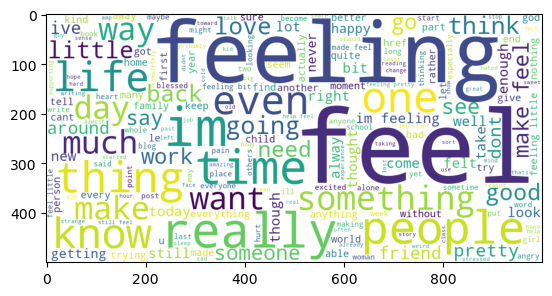

In [15]:
word_cloud = ""
for row in corpus:
    for word in row:
        word_cloud+=" ".join(word)
wordcloud = WordCloud(width = 1000, height = 500,background_color ='white',min_font_size = 10).generate(word_cloud)
plt.imshow(wordcloud)

using bigram model

In [16]:
cv = CountVectorizer(ngram_range=(1,2))
traindata = cv.fit_transform(corpus)

In [17]:
X = traindata
y = df.label

In [18]:
parameters = {'max_features': ('auto','sqrt'),
             'n_estimators': [100,200,300],
             'max_depth': [5, 10, None],
             'min_samples_split': [5, 10, 15],
             'min_samples_leaf': [1, 2, 5, 10],
             'bootstrap': [True, False]}

In [19]:
grid_search = RandomizedSearchCV(RandomForestClassifier(),parameters,cv=5,return_train_score=True,n_jobs=-1)
grid_search.fit(X,y)
grid_search.best_params_

{'n_estimators': 100,
 'min_samples_split': 15,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [20]:
rfc = RandomForestClassifier(max_features=grid_search.best_params_['max_features'],
                                      max_depth=grid_search.best_params_['max_depth'],
                                      n_estimators=grid_search.best_params_['n_estimators'],
                                      min_samples_split=grid_search.best_params_['min_samples_split'],
                                      min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                                      bootstrap=grid_search.best_params_['bootstrap'])


rfc.fit(X,y)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=15)

In [4]:
#trying our model on test data

In [21]:
test_df = pd.read_csv('test.txt',delimiter=';',names=['text','label'])


X_test,y_test = test_df.text,test_df.label
#encode the labels into two classes , 0 and 1

test_df = custom_encoder(y_test)
#pre-processing of text

test_corpus = text_transformation(X_test)
#convert text data into vectors

testdata = cv.transform(test_corpus)
#predict the target

predictions = rfc.predict(testdata)

In [6]:
#model results

In [22]:
acc_score = accuracy_score(y_test,predictions)
pre_score = precision_score(y_test,predictions)
rec_score = recall_score(y_test,predictions)
print('Accuracy_score: ',acc_score)
print('Precision_score: ',pre_score)
print('Recall_score: ',rec_score)
print("-"*50)
cr = classification_report(y_test,predictions)
print(cr)

Accuracy_score:  0.9635
Precision_score:  0.9753086419753086
Recall_score:  0.9445652173913044
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      1080
           1       0.98      0.94      0.96       920

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [7]:
#plotting roc_cuc cruve

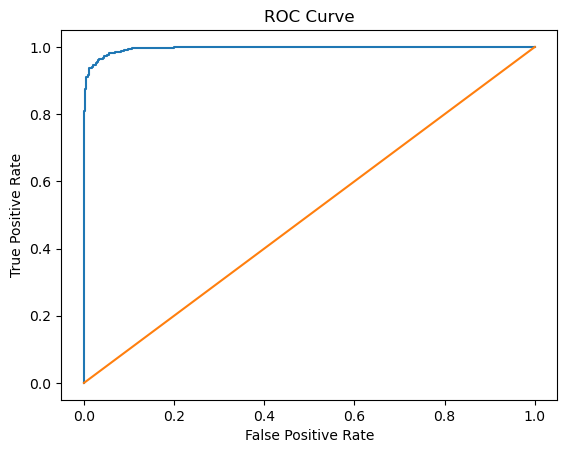

In [23]:
predictions_probability = rfc.predict_proba(testdata)
fpr,tpr,thresholds = roc_curve(y_test,predictions_probability[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Predict for Custom Input

In [24]:
def expression_check(prediction_input):
    if prediction_input == 0:
        print("Input statement has Negative Sentiment.")
    elif prediction_input == 1:
        print("Input statement has Positive Sentiment.")
    else:
        print("Invalid Statement.")
        
        
# function to take the input statement and perform the same transformations we did earlier
def sentiment_predictor(input):
    input = text_transformation(input)
    transformed_input = cv.transform(input)
    prediction = rfc.predict(transformed_input)
    expression_check(prediction)
    
    
    
input1 = ["Sometimes I just want to punch someone in the face."]
input2 = ["I bought a new phone and it's so good."]


sentiment_predictor(input1)
sentiment_predictor(input2)

Input statement has Negative Sentiment.
Input statement has Negative Sentiment.
